# **Detecting anomaly images using AutoEncoders Keras,Trensorflow framework.**

First,Sorting an entire image as either normal or anomaly.

I have use both the reconstruction error and also the kernel density estimation based on the vectors in the latent space. I will consider the bottleneck layer outputfrom our autoencoder as the latent space. 

In [1]:
#Import Libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
#Size of our input images
SIZE = 128


In [5]:
#Define generators for training, validation and also anomaly data.

batch_size = 2
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/Extend AI/Dataset-TensorFlow/Normal_train',target_size=(SIZE, SIZE),batch_size=batch_size,class_mode='input')

validation_generator = datagen.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/Extend AI/Dataset-TensorFlow/Normal_test',target_size=(SIZE, SIZE),batch_size=batch_size,class_mode='input')

anomaly_generator = datagen.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/Extend AI/Dataset-TensorFlow/Anomaly',target_size=(SIZE, SIZE),batch_size=batch_size,class_mode='input')

Found 4 images belonging to 1 classes.
Found 4 images belonging to 1 classes.
Found 3 images belonging to 1 classes.


In [6]:
#Define the autoencoder.
#I tried to make the bottleneck layer size as small as possible for density calculations and also picking appropriate thresholds. 

#Encoder
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3)))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))

In [7]:
#Decoder
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 16)       0

In [8]:
#Fit the model. 
history = model.fit(train_generator,steps_per_epoch= 5 // batch_size,epochs=50,validation_data=validation_generator,validation_steps=75 // batch_size,
        shuffle = True)

Epoch 1/50
2/2 [==============================] - ETA: 0s - loss: 0.0786 - mse: 0.0786

2/2 [==============================] - 4s 3s/step - loss: 0.0786 - mse: 0.0786 - val_loss: 0.0455 - val_mse: 0.0455
Epoch 2/50
2/2 [==============================] - 1s 318ms/step - loss: 0.0344 - mse: 0.0344
Epoch 3/50
2/2 [==============================] - 1s 404ms/step - loss: 0.0236 - mse: 0.0236
Epoch 4/50
2/2 [==============================] - 1s 315ms/step - loss: 0.0166 - mse: 0.0166
Epoch 5/50
2/2 [==============================] - 1s 347ms/step - loss: 0.0125 - mse: 0.0125
Epoch 6/50
2/2 [==============================] - 1s 271ms/step - loss: 0.0156 - mse: 0.0156
Epoch 7/50
2/2 [==============================] - 1s 301ms/step - loss: 0.0111 - mse: 0.0111
Epoch 8/50
2/2 [==============================] - 1s 316ms/step - loss: 0.0095 - mse: 0.0095
Epoch 9/50
2/2 [==============================] - 1s 308ms/step - loss: 0.0108 - mse: 0.0108
Epoch 10/50
2/2 [==============================] - 1s 332ms/step - loss: 0.0094 - mse: 0.0094
Epoch 11/50
2/2 [=============================

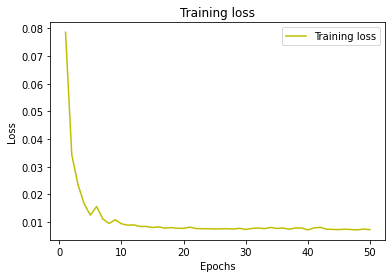

In [9]:
#plot the training and loss at each epoch
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
# Get all batches generated by the datagen and pick a batch for prediction Just to test the model. 
data_batch = []  #Capture all training batches as a numpy array
img_num = 0
while img_num <= train_generator.batch_index:   #gets each generated batch of size batch_size
    data = train_generator.next()
    data_batch.append(data[0])
    img_num = img_num + 1

In [11]:
predicted = model.predict(data_batch[0])  #Predict on the first batch of images

1/1 [==============================] - 0s 177ms/step


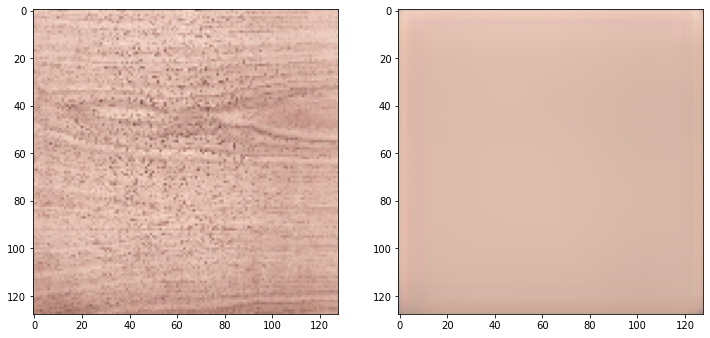

In [12]:
#Sanity check, view few images and corresponding reconstructions
image_number = random.randint(0, predicted.shape[0])
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(data_batch[0][image_number])
plt.subplot(122)
plt.imshow(predicted[image_number])
plt.show()

In [13]:
#Let us examine the reconstruction error between our validation data (good/normal images) and the anomaly images
validation_error = model.evaluate_generator(validation_generator)
anomaly_error = model.evaluate_generator(anomaly_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
print("Recon. error for the validation (normal) data is: ", validation_error)
print("Recon. error for the anomaly data is: ", anomaly_error)


Recon. error for the validation (normal) data is:  [0.00726349139586091, 0.00726349139586091]
Recon. error for the anomaly data is:  [0.007397189270704985, 0.007397189270704985]


In [15]:
#Let us extract (or build) the encoder network, with trained weights.
#This is used to get the compressed output (latent space) of the input image. 
#The compressed output is then used to calculate the KDE.

encoder_model = Sequential()
encoder_model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3), weights=model.layers[0].get_weights()) )
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.add(Conv2D(32, (3, 3), activation='relu', padding='same', weights=model.layers[2].get_weights()))
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.add(Conv2D(16, (3, 3), activation='relu', padding='same', weights=model.layers[4].get_weights()))
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 16)      

In [16]:
# Calculate KDE using sklearn
from sklearn.neighbors import KernelDensity

In [17]:
#Get encoded output of input images = Latent space
encoded_images = encoder_model.predict_generator(train_generator)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


In [18]:
# Flatten the encoder output because KDE from sklearn takes 1D vectors as input
encoder_output_shape = encoder_model.output_shape #Here, we have 16x16x16
out_vector_shape = encoder_output_shape[1]*encoder_output_shape[2]*encoder_output_shape[3]

encoded_images_vector = [np.reshape(img, (out_vector_shape)) for img in encoded_images]


In [19]:
#Fit KDE to the image latent data
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(encoded_images_vector)

In [20]:
#Calculate density and reconstruction error to find their means values for normal and anomaly images. 
#Use these mean and sigma to set thresholds. 
def calc_density_and_recon_error(batch_images):
    
    density_list=[]
    recon_error_list=[]
    for im in range(0, batch_images.shape[0]-1):
        
        img  = batch_images[im]
        img = img[np.newaxis, :,:,:]
        encoded_img = encoder_model.predict([[img]]) # Create a compressed version of the image using the encoder
        encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img] # Flatten the compressed image
        density = kde.score_samples(encoded_img)[0] # get a density score for the new image
        reconstruction = model.predict([[img]])
        reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]
        density_list.append(density)
        recon_error_list.append(reconstruction_error)
        
    average_density = np.mean(np.array(density_list))  
    stdev_density = np.std(np.array(density_list)) 
    
    average_recon_error = np.mean(np.array(recon_error_list))  
    stdev_recon_error = np.std(np.array(recon_error_list)) 
    
    return average_density, stdev_density, average_recon_error, stdev_recon_error


In [21]:
#Get average and std dev. of density and recon. error for uninfected and anomaly (parasited) images. 
#Generate a batch of images for each. 
train_batch = train_generator.next()[0]
anomaly_batch = anomaly_generator.next()[0]

uninfected_values = calc_density_and_recon_error(train_batch)
anomaly_values = calc_density_and_recon_error(anomaly_batch)



1/1 [==============================] - 0s 38ms/step - loss: 0.0119 - mse: 0.0119


In [22]:
#Now, input unknown images and sort as Good or Anomaly
def check_anomaly(img_path):
    density_threshold = 2500 #Set this value based on the above exercise
    reconstruction_error_threshold = 0.004 # Set this value based on the above exercise
    img  = Image.open(img_path)
    img = np.array(img.resize((128,128), Image.ANTIALIAS))
    plt.imshow(img)
    img = img / 255.
    img = img[np.newaxis, :,:,:]
    encoded_img = encoder_model.predict([[img]]) 
    encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img] 
    density = kde.score_samples(encoded_img)[0] 

    reconstruction = model.predict([[img]])
    reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]

    if density < density_threshold or reconstruction_error > reconstruction_error_threshold:
        print("The image is an anomaly")
        
    else:
        print("The image is NOT an anomaly")

1/1 [==============================] - 0s 37ms/step - loss: 0.0111 - mse: 0.0111
The image is an anomaly
1/1 [==============================] - 0s 38ms/step - loss: 0.0025 - mse: 0.0025
The image is NOT an anomaly


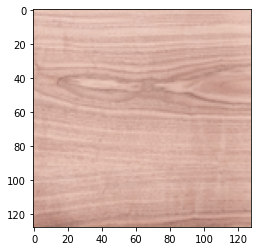

In [27]:
#Load a couple of test images and verify whether they are reported as anomalies.
import glob
anomaly_file_paths = glob.glob('/content/drive/MyDrive/Colab Notebooks/Extend AI/Dataset-TensorFlow/Anomaly/images/*')
normal_file_paths = glob.glob('/content/drive/MyDrive/Colab Notebooks/Extend AI/Dataset-TensorFlow/Normal_train/images/*')

#Anomaly image verification
num=random.randint(0,len(anomaly_file_paths)-1)
check_anomaly(anomaly_file_paths[num])

#Good/normal image verification
num=random.randint(2,len(anomaly_file_paths)-1)
check_anomaly(normal_file_paths[num])



Conclusion

Followimg are the improvments for future work:

Need for Data Augmentation for small real world dataset,such as test-time augmentation. Based on my reseach pretarined model need large amount to dataset. More hyper parameter tunnig on different model parameters by freezing and adding some layers.

Transfer Learning to other types of surfaces:

To identify anomolies in other metals such as iron, steel etc. Fully trained model on wood dataset and it's weights can be used to identify low -level features like boundries/edges with first some layers and final layers to identify high-level features with some data augmentation, adding data and fine tunning. For example for Mask R-CNN detection model famous coco dataset trained weights are used.